In [1]:
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

# Импорт необходимых модулей
from scripts.calibrate_models import calibrate_fx_model, calibrate_models
from scripts.compare_models import compare_models, create_model
from scripts.simulate_model import simulate_model
from src.models import CIRModel, FXLogModel
from src.pricing import RangeAccrualPricingModel
from src.utils import get_cir_residuals, get_logfx_residuals, get_theta_arr
from src.visualization.plots import plot_fx_analysis, plot_historical_data, plot_simulation
from src.visualization.stats import print_best_params, print_statistics

warnings.filterwarnings("ignore")

# SORF

SOFR отражает стоимость overnight-кредитования под залог казначейских ценных бумаг

In [2]:
raw_sofr_df = pd.read_excel("data/us-sofr.xlsx")
raw_sofr_df = raw_sofr_df.rename(columns={"Effective Date": "Date", "Rate (%)": "Rate"})[
    ["Date", "Rate"]
]
raw_sofr_df["Date"] = pd.to_datetime(raw_sofr_df["Date"])
raw_sofr_df["Rate"] = raw_sofr_df["Rate"] / 100

Статистика и график исторических данных SOFR, показывающий динамику ставки за анализируемый период.

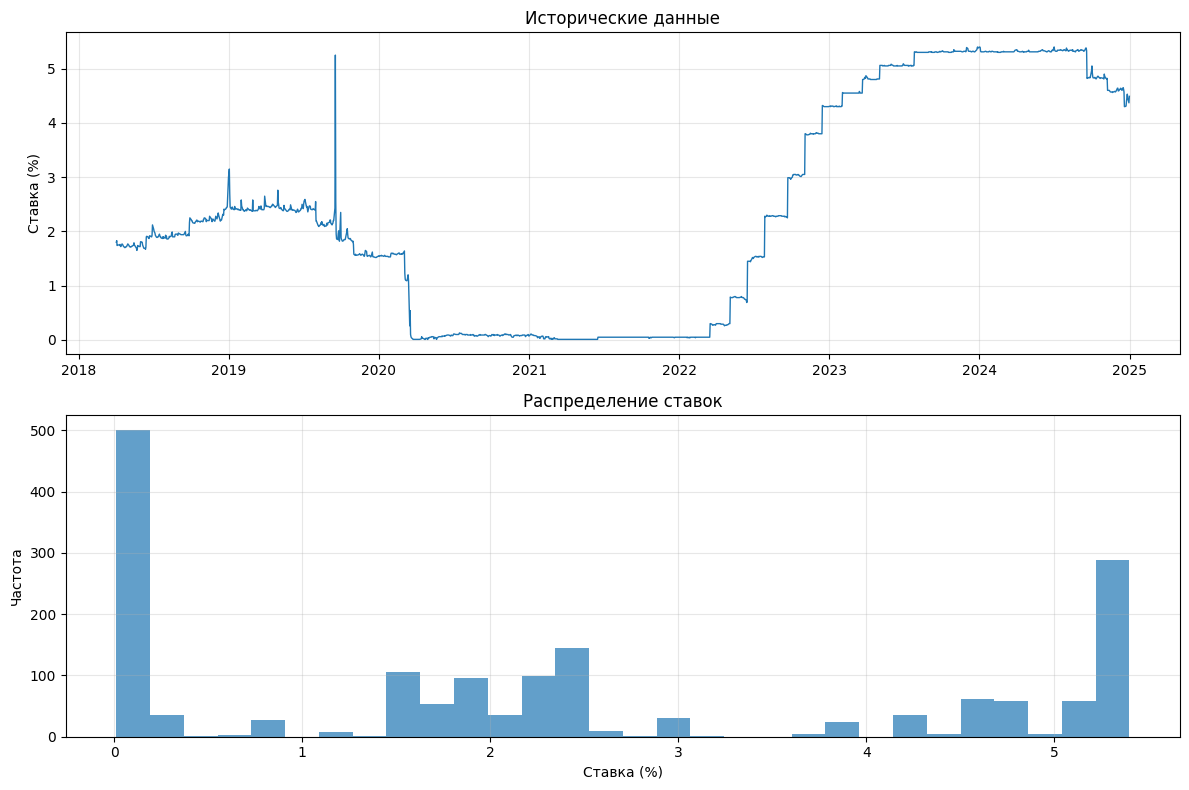

In [3]:
plot_historical_data(raw_sofr_df)

Определение временных параметров анализа.
В качестве исторических данных для калибровки параметров модели выбран период с июня 2018 года, он позволяет охватить разные фазы рынка: период постепенного повышения ставок, их резкое падение во время пандемии 2020 года. Данные SOFR за этот период показывают высокую волатильность — от значений близких к нулю до 5% и выше, что хорошо видно по широкому распределению ставок на гистограмме. Это делает период репрезентативным для моделирования различных сценариев.
Горизонт прогнозирования, релевантный для большинства финансовых инструментов, равен одному году. 

In [4]:
calc_date = pd.Timestamp("2021-12-10")
start_date = raw_sofr_df["Date"].min()
end_date = calc_date + pd.Timedelta(days=365)

In [5]:
# Фильтруем данные до нашей расчетной даты
sofr_hist = raw_sofr_df[
    (raw_sofr_df["Date"] >= start_date) & (raw_sofr_df["Date"] <= calc_date)
].copy()
sofr_df = sofr_hist.dropna()

# Берем ставку на расчетную дату
sofr_initial = sofr_hist[sofr_hist["Date"] == calc_date]["Rate"].values[0]
print(f"Начальная ставка SOFR на 10.12.2021: {sofr_initial * 100:.4f}%")

Начальная ставка SOFR на 10.12.2021: 0.0500%


СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 925 наблюдений
• Минимальный ставка: 0.0100 %
• Максимальный ставка: 5.2500 %
• Средний ставка: 1.1053 %
• Медиана: 1.5400 %
• Стандартное отклонение: 1.0318 %
• Коэффициент вариации: 0.9335

• 25-й перцентиль: 0.0500 %
• 75-й перцентиль: 2.1200 %
• IQR: 2.0700 %

Анализ изменений ставок:
• Среднее дневное изменение: 0.0019%
• Волатильность изменений: 0.1437%
• Макс. рост за день: 2.7000%
• Макс. падение за день: -2.8200%


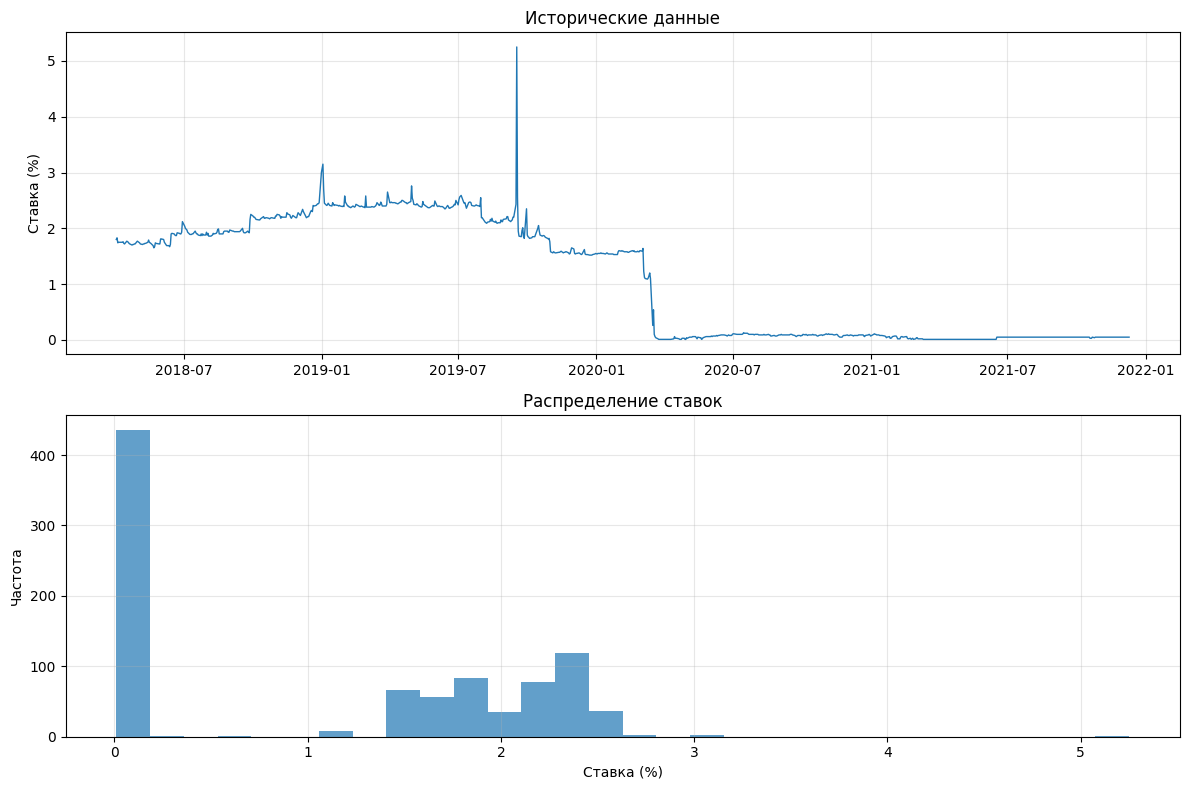

In [6]:
print_statistics(sofr_df["Rate"])
plot_historical_data(sofr_df)

Статистика данных SOFR до 2022 года показывает ставки в диапазоне от 0.01% до 5.25% со средним значением 1.1%. Основная масса наблюдений сосредоточена в нижнем диапазоне, что видно по медиане 1.54% и 75-му процентилю 2.12%, при этом стандартное отклонение составляет 1.03%, подтверждая умеренную волатильность за этот период. Распределение ставок резко смещено влево, с огромной концентрацией значений около 0%, что видно на гистограмме.

## T-bills

T-bills — это краткосрочные гособлигации США, главный безрисковый актив. Их доходность напрямую зависит от ставки ФРС. В работе используется кривая с прогнозированием на 3 месяца. Данный период достаточен для калибровки краткосрочного прогнозирования CIR моделью.

In [7]:
us_g_curve_df = pd.read_excel("data/t-bills.xlsx")
us_g_curve_df = us_g_curve_df.rename(columns={"observation_date": "Date", "DGS3MO": "Rate"})[
    ["Date", "Rate"]
]
us_g_curve_df["Date"] = pd.to_datetime(us_g_curve_df["Date"])
us_g_curve_df["Rate"] = us_g_curve_df["Rate"] / 100

# Фильтруем данные до нашей расчетной даты
us_g_curve_df = us_g_curve_df[
    (us_g_curve_df["Date"] >= start_date) & (us_g_curve_df["Date"] <= calc_date)
].copy()
us_g_curve_df = us_g_curve_df.dropna()

СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 926 наблюдений
• Минимальный ставка: 0.0000 %
• Максимальный ставка: 2.4900 %
• Средний ставка: 1.1034 %
• Медиана: 1.5400 %
• Стандартное отклонение: 1.0126 %
• Коэффициент вариации: 0.9177

• 25-й перцентиль: 0.0800 %
• 75-й перцентиль: 2.0800 %
• IQR: 2.0000 %

Анализ изменений ставок:
• Среднее дневное изменение: -0.0018%
• Волатильность изменений: 0.0236%
• Макс. рост за день: 0.1100%
• Макс. падение за день: -0.2300%


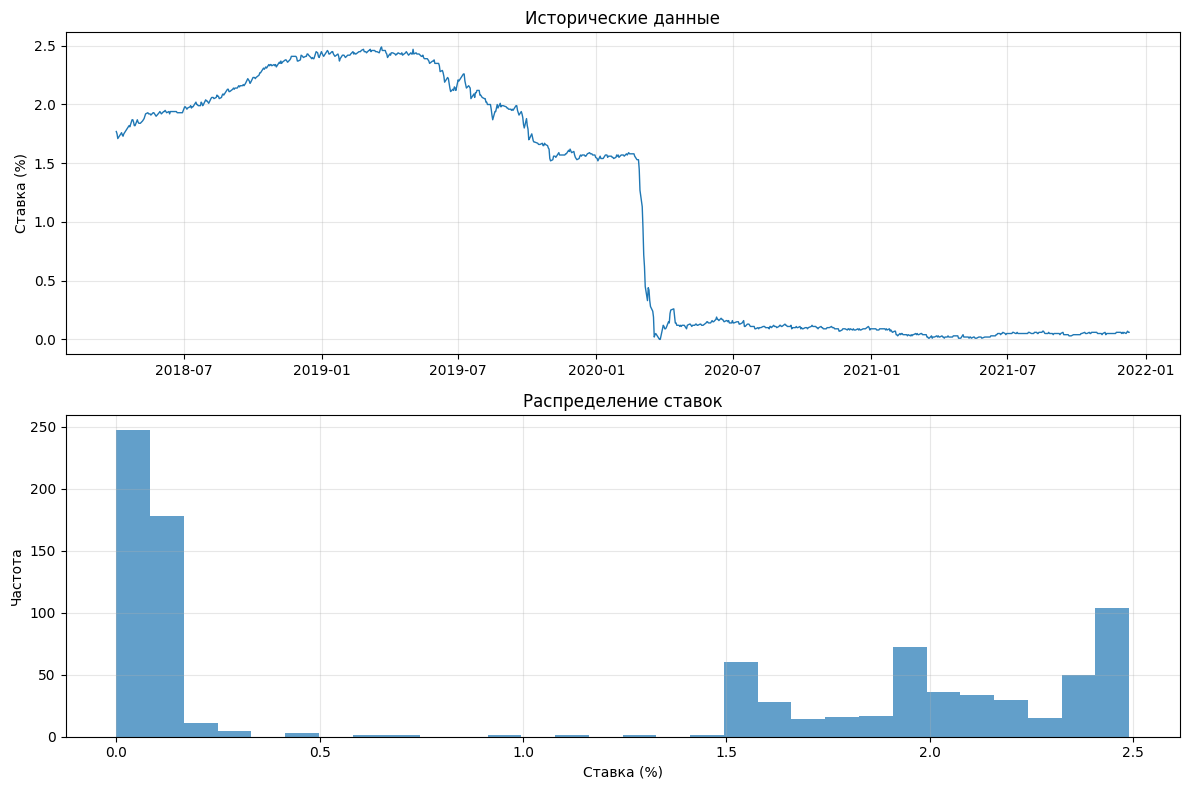

In [8]:
print_statistics(us_g_curve_df["Rate"])
plot_historical_data(us_g_curve_df)

Данные показывают период низких ставок с медианой 0,12%. Волатильность была минимальной — стандартное отклонение всего 0,093%. Распределение сильно смещено к нулю, что характерно для политики нулевых ставок ФРС.

Ключевые наблюдения по сравнению SOFR и T-bills:

- Схожий диапазон но разное распределение

- Более низкая волатильность T-bills, т.к. практически безрисковый актив

- Значительно меньшие выбросов - плавная динамика

Различия отражают разные природы инструментов. SOFR более чувствителен к краткосрочным ликвидностным шокам. T-bills отражает ожидания денежной политики


Калибровка моделей...
1. Модель с постоянной theta...
   α=0.0010, σ=0.1764, θ=0.0003
Условие Феллера: НЕ ВЫПОЛНЕНО (2αθ = 0.000001 ≤ σ² = 0.031107)
2. Модель с theta на основе G-кривой (spline)...
   α=0.1468, σ=0.1762
Условие Феллера: ВЫПОЛНЕНО ДЛЯ ВСЕХ t
2. Модель с theta на основе G-кривой (piecewise)...
   α=0.1468, σ=0.1762
Условие Феллера: ВЫПОЛНЕНО ДЛЯ ВСЕХ t

Симуляция constant модели...


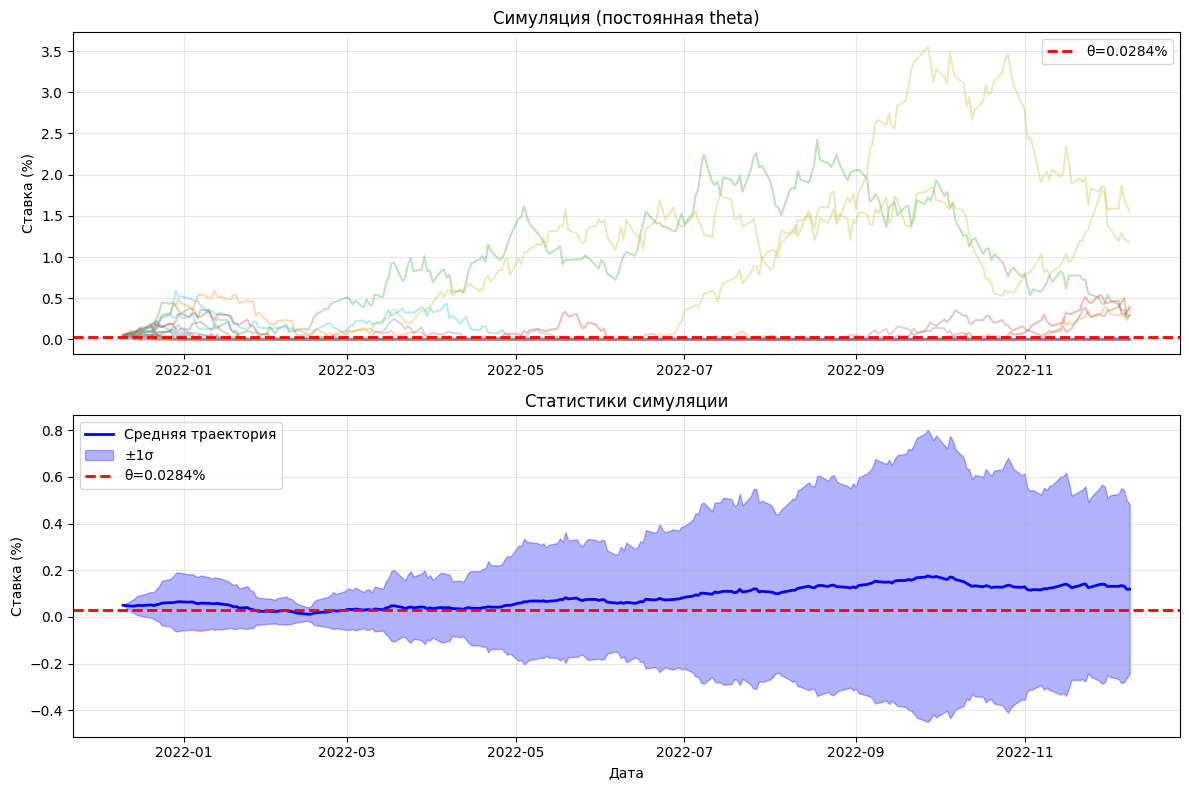


Симуляция g_curve_spline модели...


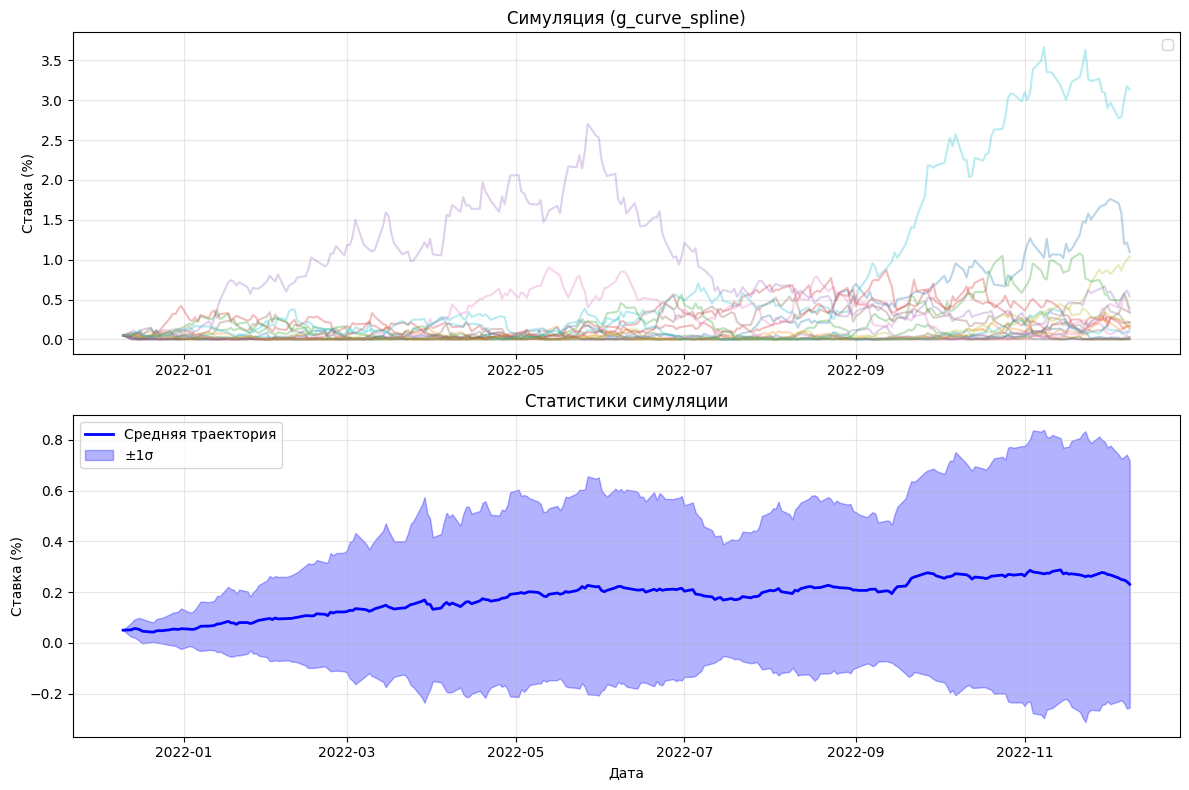


Симуляция g_curve_piecewise модели...


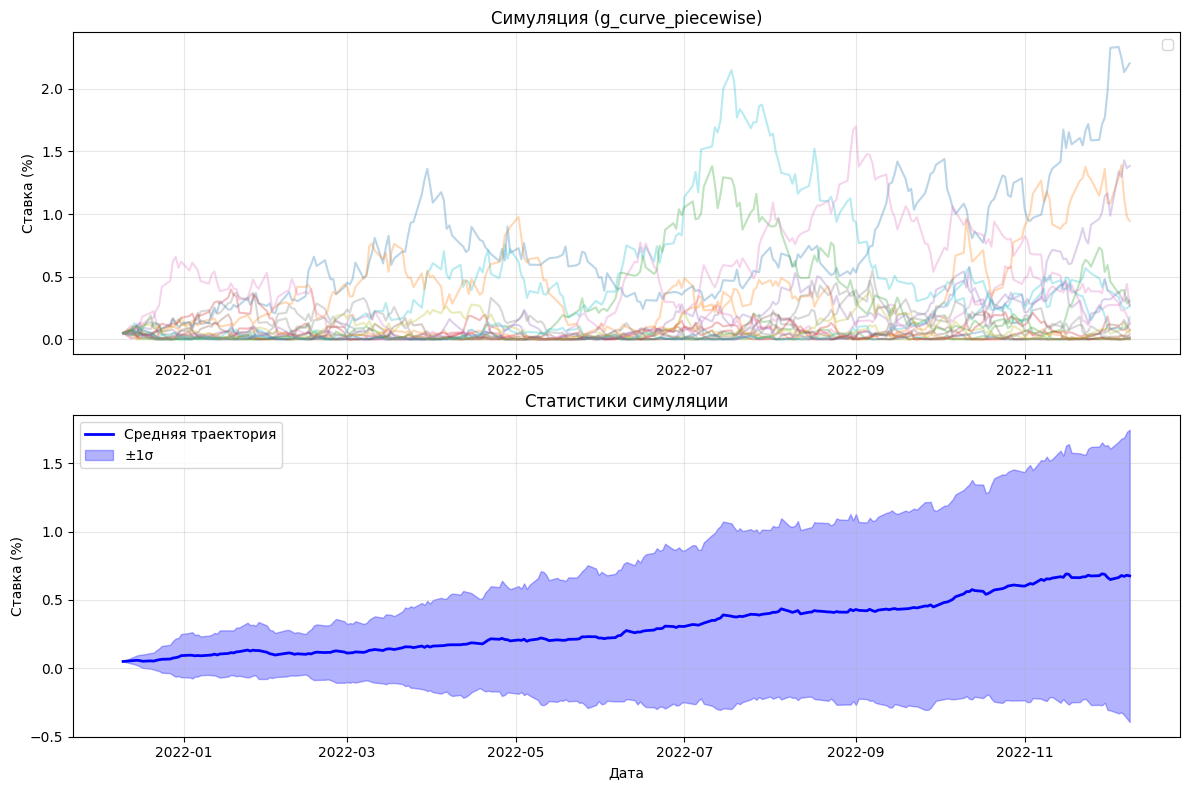

In [9]:
# Калибровка
models = calibrate_models(sofr_df["Rate"].values, mode="sofr", g_curve_data=us_g_curve_df)

# Симуляция для каждой модели
for model_type in models:
    print(f"\nСимуляция {model_type} модели...")
    model = create_model(models[model_type], model_type)
    dates, trajectories = simulate_model(
        model=model,
        initial_value=sofr_initial,
        start_date=calc_date,
        end_date=end_date,
        n_paths=50,
        model_type="rate",
    )
    plot_simulation(dates, trajectories, model_type, models[model_type])

Параметры CIR-модели откалиброваны на исторических данных методом максимального правдоподобия. При калибровке параметров модели CIR критически важно соблюдение условия Феллера, гарантирующего неотрицательность ставок.
2αθ(t) > σ² для всех t в рассматриваемом временном диапазоне.
Нарушение условия может привести к финансово некорректным результатам, включая отрицательные значения ставок.

В CIR модели параметр тетта (θ) — это долгосрочное равновесное значение процентной ставки. Существует два подхода к его калибровке:
Исторический подход: использует среднее значение прошлых данных ставки. Он прост и устойчив к краткосрочным колебаниям, однако не учитывает текущие рыночные ожидания и может быть не актуален в периоды резких изменений. При калибровке постоянного параметра θ в работе используется метод максимального правдоподобия на исторических данных. Исходное значение θ принимается равным среднему историческому значению ставки. Затем проводится совместная оптимизация всех параметров модели (α, σ, θ) для достижения наилучшего соответствия фактическим данным.

Второй подход к калибровке параметра θ(t) основан на использовании текущей кривой бескупонной доходности (G-кривой) в качестве исходных данных. Кривая доходности отражает совокупные ожидания рынка относительно будущей динамики процентных ставок, что позволяет определить не постоянное, а изменяющееся во времени значение долгосрочного среднего.


СРАВНЕНИЕ МОДЕЛЕЙ
Постоянная θ: LogL = 5494.2631
  θ = 0.0003 (0.03%)
G-кривая θ: LogL = 5495.2229
  Диапазон ставок: 0.00% - 2.49%
G-кривая θ: LogL = 5495.2226
  Диапазон ставок: 0.00% - 2.49%

Построение графиков сравнения...


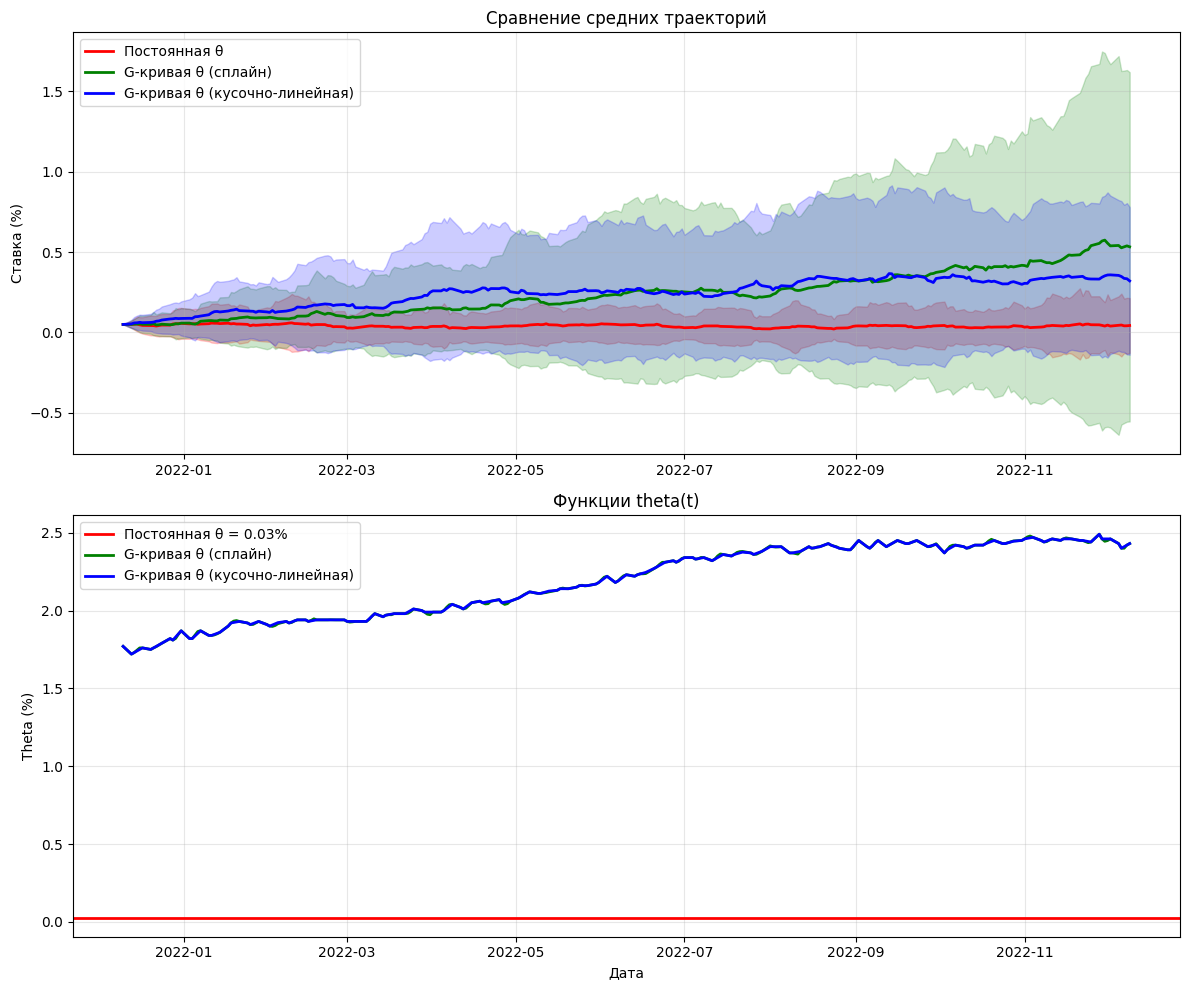

In [10]:
compare_models(models, sofr_initial, calc_date, end_date)

На представленном графике видно, что при очень низком уровне постоянной θ (0.03%) все три метода калибровки дают схожие результаты. Однако даже в этой ситуации калибровка на основе G-кривой предпочтительнее, особенно метод сплайн-интерполяции.
Постоянная θ = 0.03% является искусственно заниженной и не отражает реальной динамики рынка. Такой уровень соответствует периоду экстремально низких ставок, но не может адекватно описывать их будущие изменения. В отличие от этого, G-кривая со сплайн-интерполяцией обеспечивает плавную адаптацию к изменяющимся рыночным условиям, что важно при выходе из сверхнизких процентных ставок.
Кусочно-линейная аппроксимация также сохраняет преимущества адаптивности, но дает менее гладкие переходы


In [11]:
print_best_params(models, "g_curve_spline")


Параметры лучшей модели (g_curve_spline):
• Alpha (α): 0.1468
• Sigma (σ): 0.1762
• Theta(t): на основе G-кривой
• Диапазон G-кривой: 0.00-3.69 лет
• Ставки G-кривой: 0.00%-2.49%
• Метод интерполяции: spline


In [12]:
us_best_params = {
    "alpha": models["g_curve_spline"]["alpha"],
    "sigma": models["g_curve_spline"]["sigma"],
    "theta_func": models["g_curve_spline"]["theta_function"],
}

# RUONIA

RUONIA — это индикатор ставки overnight на российском межбанковском рынке, аналог SOFR для рубля

In [13]:
raw_ruonia_df = pd.read_excel("data/ru-ruonia.xlsx")
raw_ruonia_df = raw_ruonia_df.rename(columns={"DT": "Date", "ruo": "Rate"})[["Date", "Rate"]]
raw_ruonia_df["Date"] = pd.to_datetime(raw_ruonia_df["Date"])
raw_ruonia_df["Rate"] = raw_ruonia_df["Rate"] / 100

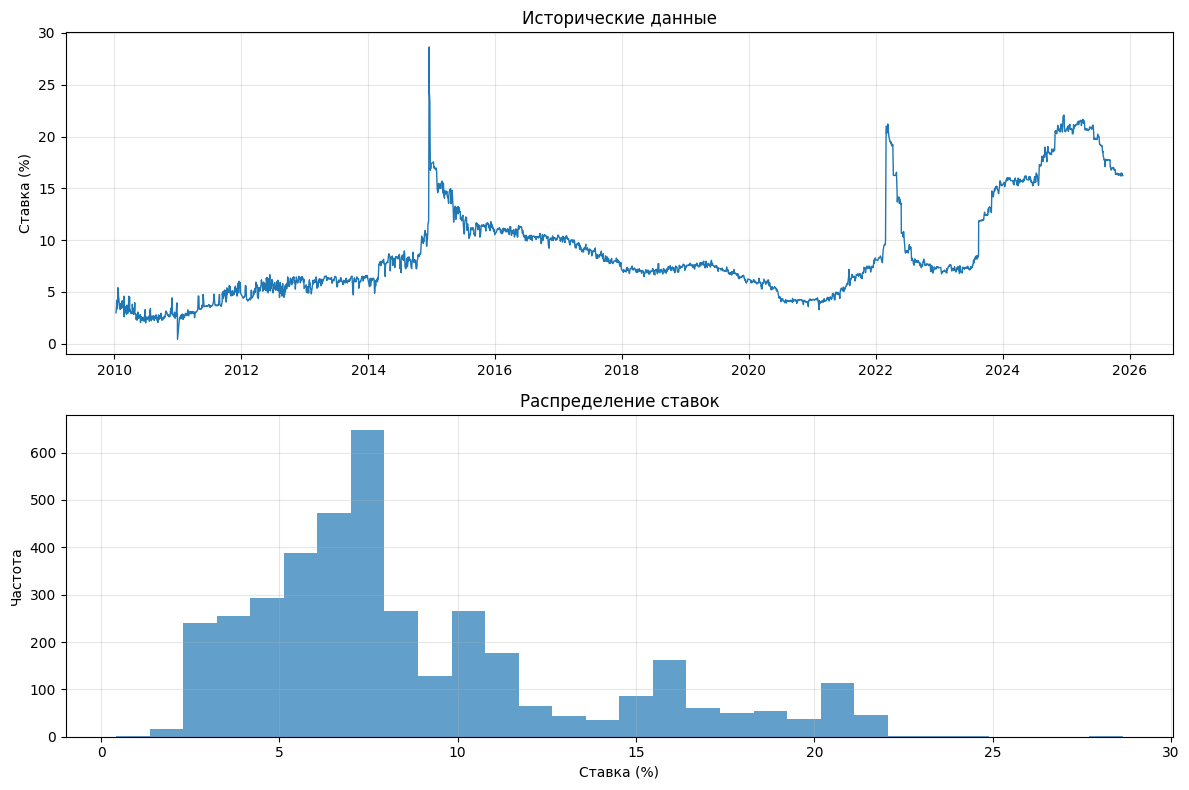

In [14]:
plot_historical_data(raw_ruonia_df)

RUONIA показывает два distinct режима: до 2016 года — высокая волатильность и ставки до 25-30%, а после — резкая стабилизация на низком уровне 0-5%. Распределение бимодальное, что наглядно отражает смену денежно-кредитной политики ЦБ.

In [15]:
calc_date = pd.Timestamp("2021-12-10")
start_date = calc_date - pd.Timedelta(days=365 * 3)
end_date = calc_date + pd.Timedelta(days=365)

In [16]:
# Фильтруем данные до нашей расчетной даты
ruonia_hist = raw_ruonia_df[
    (raw_ruonia_df["Date"] >= start_date) & (raw_ruonia_df["Date"] <= calc_date)
].copy()
ruonia_df = ruonia_hist.dropna()

# Берем ставку на расчетную дату
ruonia_initial = ruonia_df[ruonia_df["Date"] == calc_date]["Rate"].values[0]
print(f"Начальная ставка SOFR на 10.12.2021: {ruonia_initial * 100:.4f}%")

Начальная ставка SOFR на 10.12.2021: 7.4500%


СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 733 наблюдений
• Минимальный ставка: 3.2800 %
• Максимальный ставка: 8.0600 %
• Средний ставка: 5.8837 %
• Медиана: 6.0200 %
• Стандартное отклонение: 1.3199 %
• Коэффициент вариации: 0.2243

• 25-й перцентиль: 4.3500 %
• 75-й перцентиль: 7.1400 %
• IQR: 2.7900 %

Анализ изменений ставок:
• Среднее дневное изменение: -0.0000%
• Волатильность изменений: 0.1376%
• Макс. рост за день: 0.5900%
• Макс. падение за день: -0.8800%


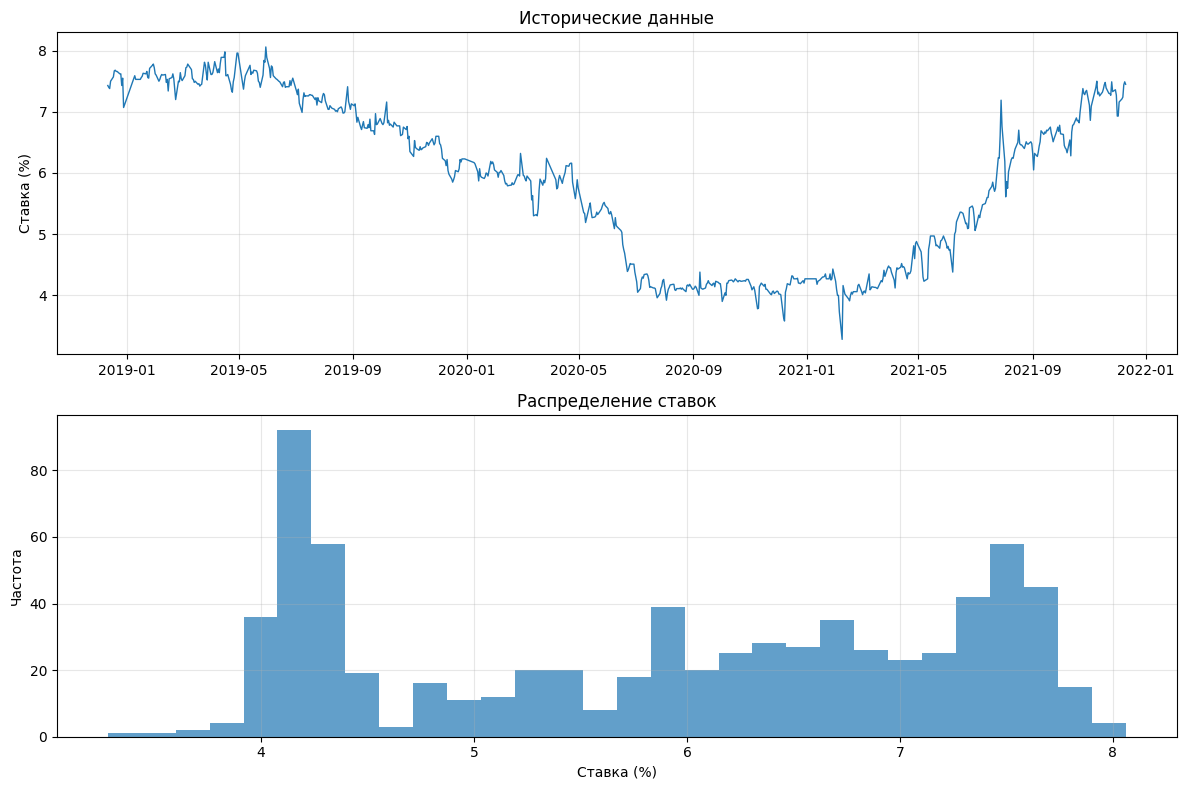

In [17]:
print_statistics(ruonia_df["Rate"])
plot_historical_data(ruonia_df)

Данные показывают ставку в диапазоне от 3.28% до 8.06% со средним значением 5.88%. Ставки были относительно высокими и стабильными: медиана 6.02% и низкая волатильность изменений (0.14%). Период взят с 2019 года, так как он представляет собой современный и структурно однородный этап денежно-кредитной политики. Исключает ранние высоковолатильные фазы и охватывает последний полный цикл до глобальных шоков 2022 года

## Zero-coupon yield curve

Кривая бескупонной доходности — это график, показывающий зависимость доходности гособлигаций от сроков погашения при условии отсутствия купонных выплат. Она отражает рыночные ожидания по будущим процентным ставкам

In [18]:
ru_g_curve_df = pd.read_excel("data/zcyc.xlsx", decimal=",")
ru_g_curve_df = ru_g_curve_df.rename(columns={"tradedate": "Date", "period_0.25": "Rate"})[
    ["Date", "Rate"]
]
ru_g_curve_df["Date"] = pd.to_datetime(ru_g_curve_df["Date"], format="%d.%m.%Y")
ru_g_curve_df["Rate"] = ru_g_curve_df["Rate"].astype(float) / 100

# Фильтруем данные до нашей расчетной даты
ru_g_curve_df = ru_g_curve_df[
    (ru_g_curve_df["Date"] >= start_date) & (ru_g_curve_df["Date"] <= calc_date)
].copy()
ru_g_curve_df = ru_g_curve_df.dropna()

СТАТИСТИКА ДАННЫХ (СТАВКА):
• Объем данных: 758 наблюдений
• Минимальный ставка: 3.0000 %
• Максимальный ставка: 8.4700 %
• Средний ставка: 5.7635 %
• Медиана: 5.7750 %
• Стандартное отклонение: 1.2849 %
• Коэффициент вариации: 0.2229

• 25-й перцентиль: 4.5625 %
• 75-й перцентиль: 6.9700 %
• IQR: 2.4075 %

Анализ изменений ставок:
• Среднее дневное изменение: 0.0006%
• Волатильность изменений: 0.2098%
• Макс. рост за день: 1.0300%
• Макс. падение за день: -1.1100%


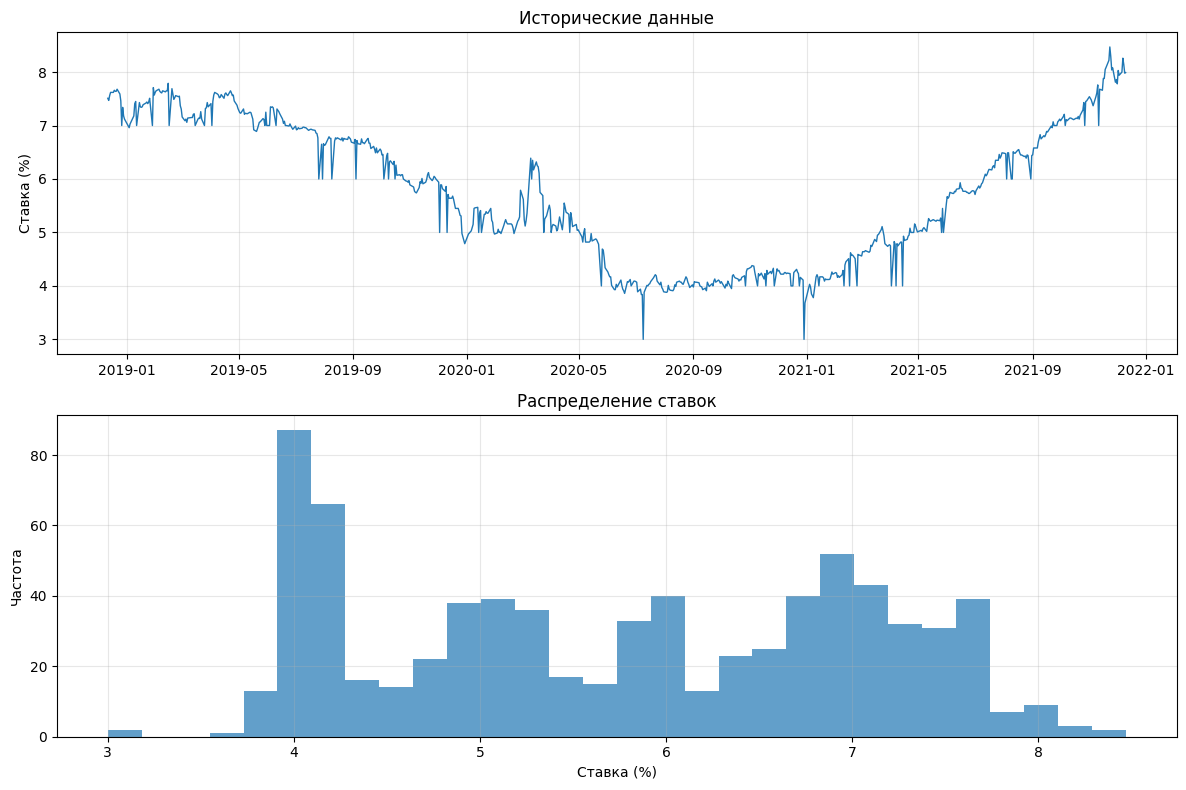

In [19]:
print_statistics(ru_g_curve_df["Rate"])
plot_historical_data(ru_g_curve_df)

Данные показывают ставку в диапазоне 3-8.5% со средней доходностью 5.76%, что свидетельствует о периоде относительно высоких и стабильных значений. Волатильность была умеренной, с максимальными дневными изменениями около 1%.

Обе ставки показывают схожий диапазон колебаний в наблюдаемый период.


Калибровка моделей...
1. Модель с постоянной theta...
   α=1.4481, σ=0.0919, θ=0.0588
Условие Феллера: ВЫПОЛНЕНО (2αθ = 0.170209 > σ² = 0.008447)
2. Модель с theta на основе G-кривой (spline)...
   α=0.0010, σ=0.0921
Условие Феллера: ВЫПОЛНЕНО ДЛЯ ВСЕХ t
2. Модель с theta на основе G-кривой (piecewise)...
   α=0.0010, σ=0.0921
Условие Феллера: ВЫПОЛНЕНО ДЛЯ ВСЕХ t

Симуляция constant модели...


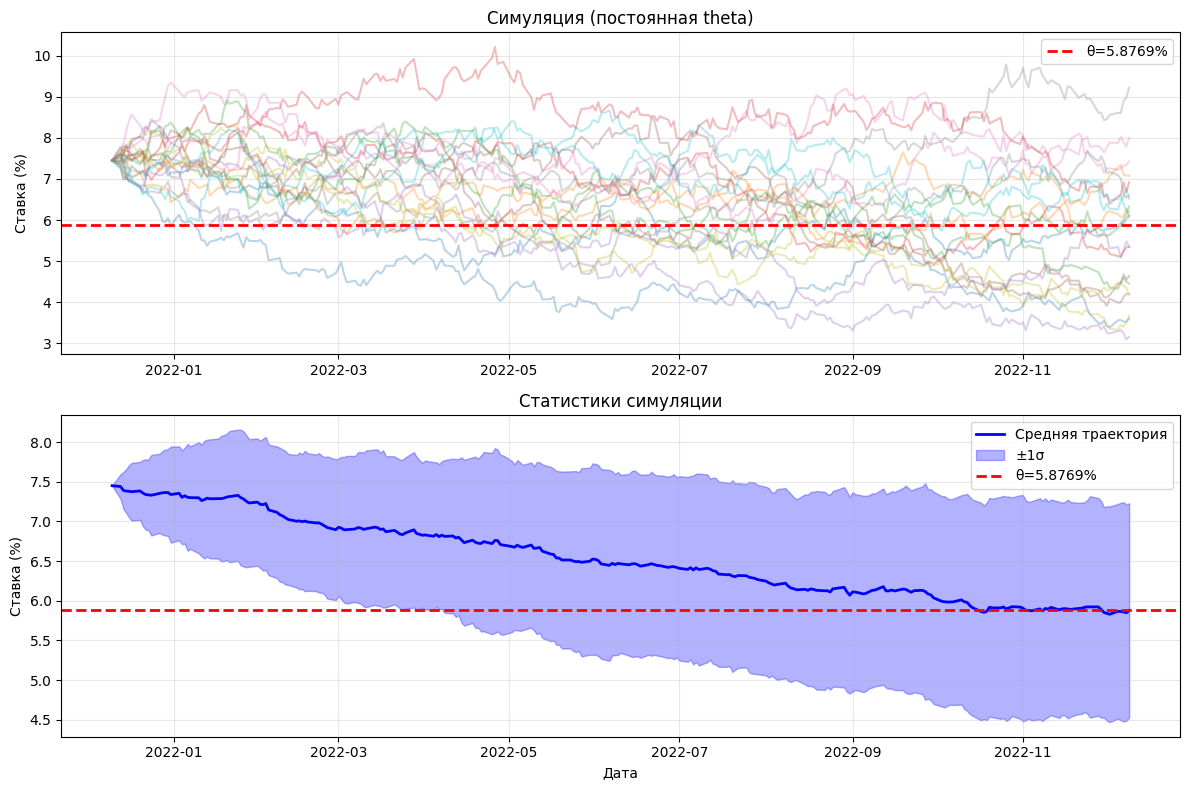


Симуляция g_curve_spline модели...


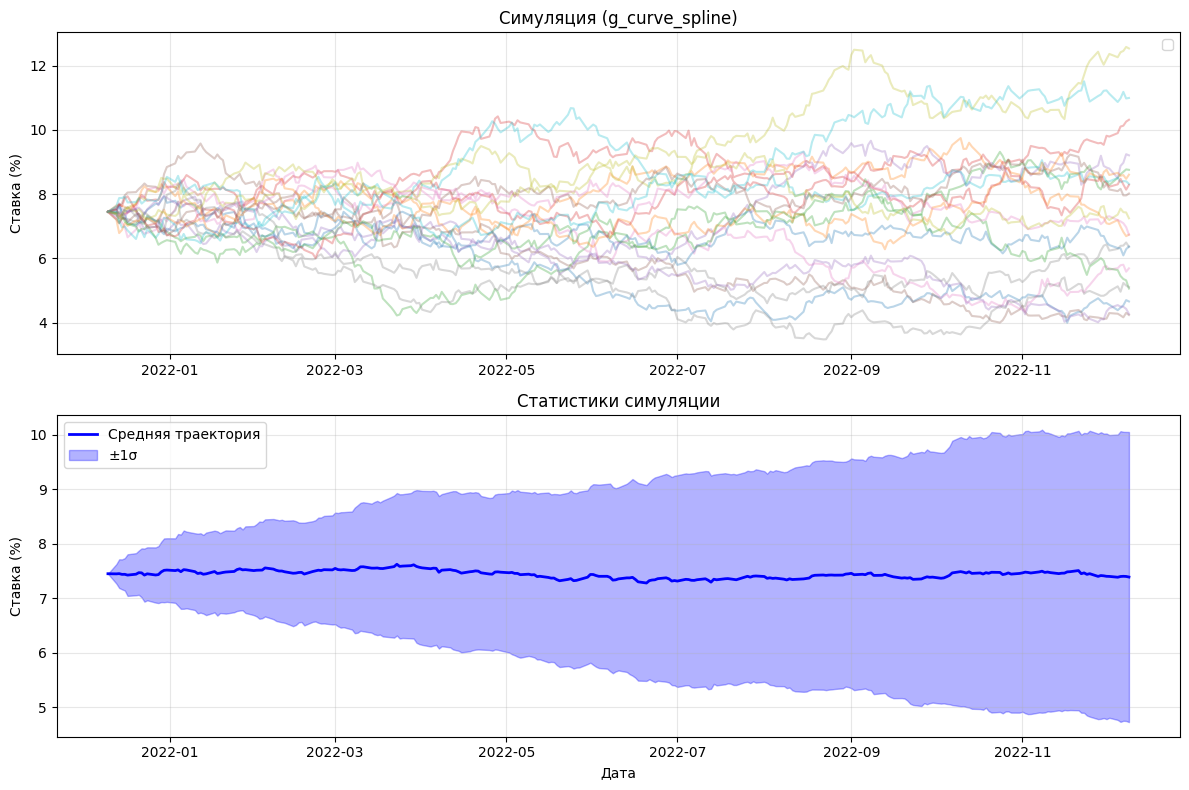


Симуляция g_curve_piecewise модели...


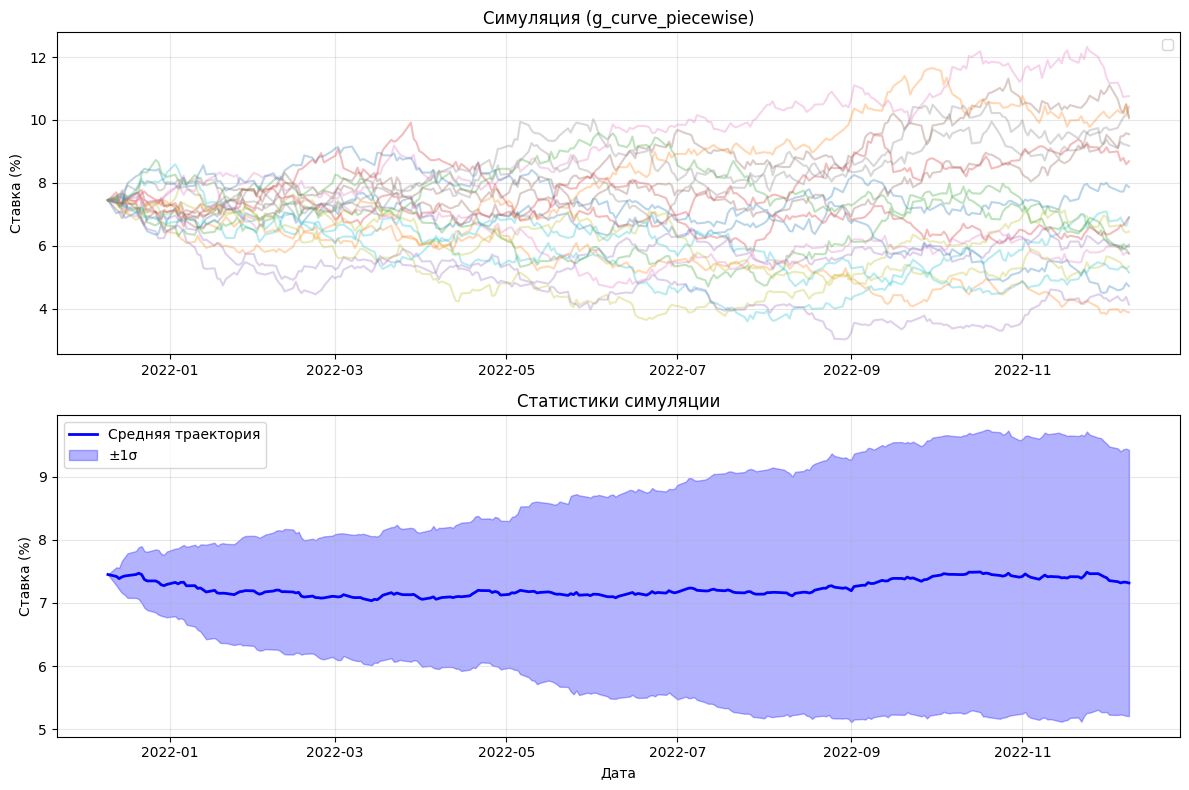

In [20]:
# Калибровка
models = calibrate_models(ruonia_df["Rate"].values, mode="rub", g_curve_data=ru_g_curve_df)

# Симуляция для каждой модели
for model_type in models:
    print(f"\nСимуляция {model_type} модели...")
    model = create_model(models[model_type], model_type)
    dates, trajectories = simulate_model(
        model=model,
        initial_value=ruonia_initial,
        start_date=calc_date,
        end_date=end_date,
        n_paths=50,
        model_type="rate",
    )
    simulate_model(model, ruonia_initial, calc_date, end_date)
    plot_simulation(dates, trajectories, model_type, models[model_type])


СРАВНЕНИЕ МОДЕЛЕЙ
Постоянная θ: LogL = 3779.1301
  θ = 0.0588 (5.88%)
G-кривая θ: LogL = 3777.9419
  Диапазон ставок: 3.00% - 8.47%
G-кривая θ: LogL = 3777.9418
  Диапазон ставок: 3.00% - 8.47%

Построение графиков сравнения...


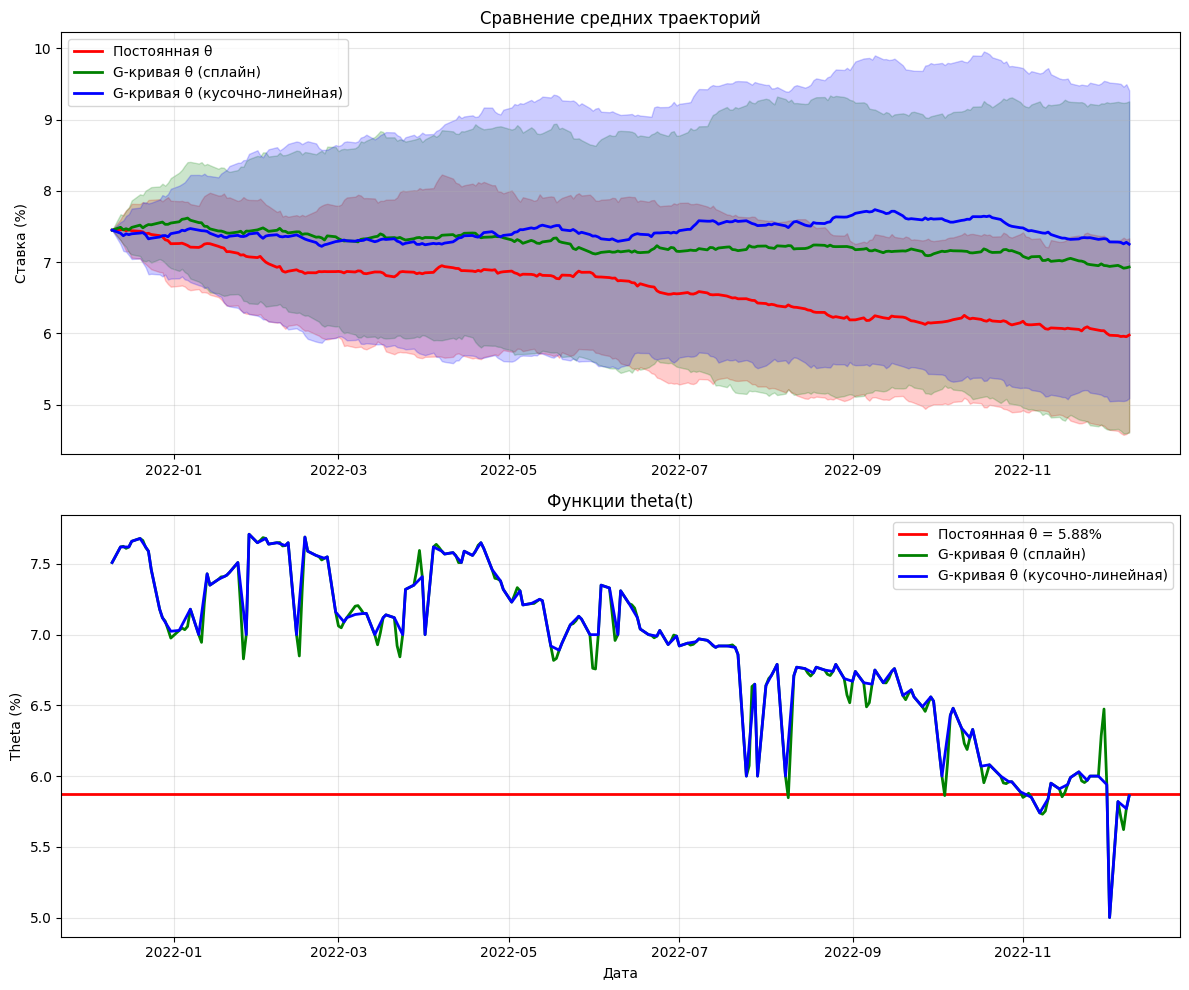

In [21]:
compare_models(models, ruonia_initial, calc_date, end_date)

На основе анализа графиков рекомендуется использовать калибровку θ на основе G-кривой со сплайн-интерполяцией. Данный метод демонстрирует лучшую адаптивность к изменяющимся рыночным условиям по сравнению с постоянной θ, которая фиксирует ставку на уровне 5.88% и не отражает текущие рыночные ожидания. При этом сплайн-интерполяция обеспечивает более плавную и реалистичную динамику по сравнению с кусочно-линейным методом. Подход с G-кривой позволяет модели учитывать временную структуру процентных ставок и лучше соответствовать актуальной рыночной информации, что особенно важно для задач оценки производных инструментов и краткосрочного прогнозирования.

In [22]:
print_best_params(models, "g_curve_spline")


Параметры лучшей модели (g_curve_spline):
• Alpha (α): 0.0010
• Sigma (σ): 0.0921
• Theta(t): на основе G-кривой
• Диапазон G-кривой: 0.00-3.00 лет
• Ставки G-кривой: 3.00%-8.47%
• Метод интерполяции: spline


In [23]:
ru_best_params = {
    "alpha": models["g_curve_spline"]["alpha"],
    "sigma": models["g_curve_spline"]["sigma"],
    "theta_func": models["g_curve_spline"]["theta_function"],
}

# RUB/USD

In [24]:
fx_df = pd.read_excel("data/rub_usd.xlsx")
fx_df = fx_df.rename(columns={"data": "Date", "curs": "Rate"})
fx_df["Date"] = pd.to_datetime(fx_df["Date"])
fx_df = fx_df.sort_values("Date")

# Оставляем период до расчётной даты
calculation_date = pd.Timestamp("2021-12-10")
fx_hist = fx_df[(fx_df["Date"] >= start_date) & (fx_df["Date"] <= calculation_date)].copy()
fx_hist = fx_hist.dropna(subset=["Rate"])

# Берём начальный курс S0 на дату 10.12.2021
fx_initial = fx_hist[fx_hist["Date"] == calculation_date]["Rate"].values[0]
print(f"Начальный курс на {calculation_date.date()}: {fx_initial:.4f} RUB за 1 USD")

Начальный курс на 2021-12-10: 73.5998 RUB за 1 USD


In [25]:
# Расчет лог-доходностей
fx_hist["LogRate"] = np.log(fx_hist["Rate"])
fx_hist["LogReturn"] = fx_hist["LogRate"].diff()
log_returns = fx_hist["LogReturn"].dropna()

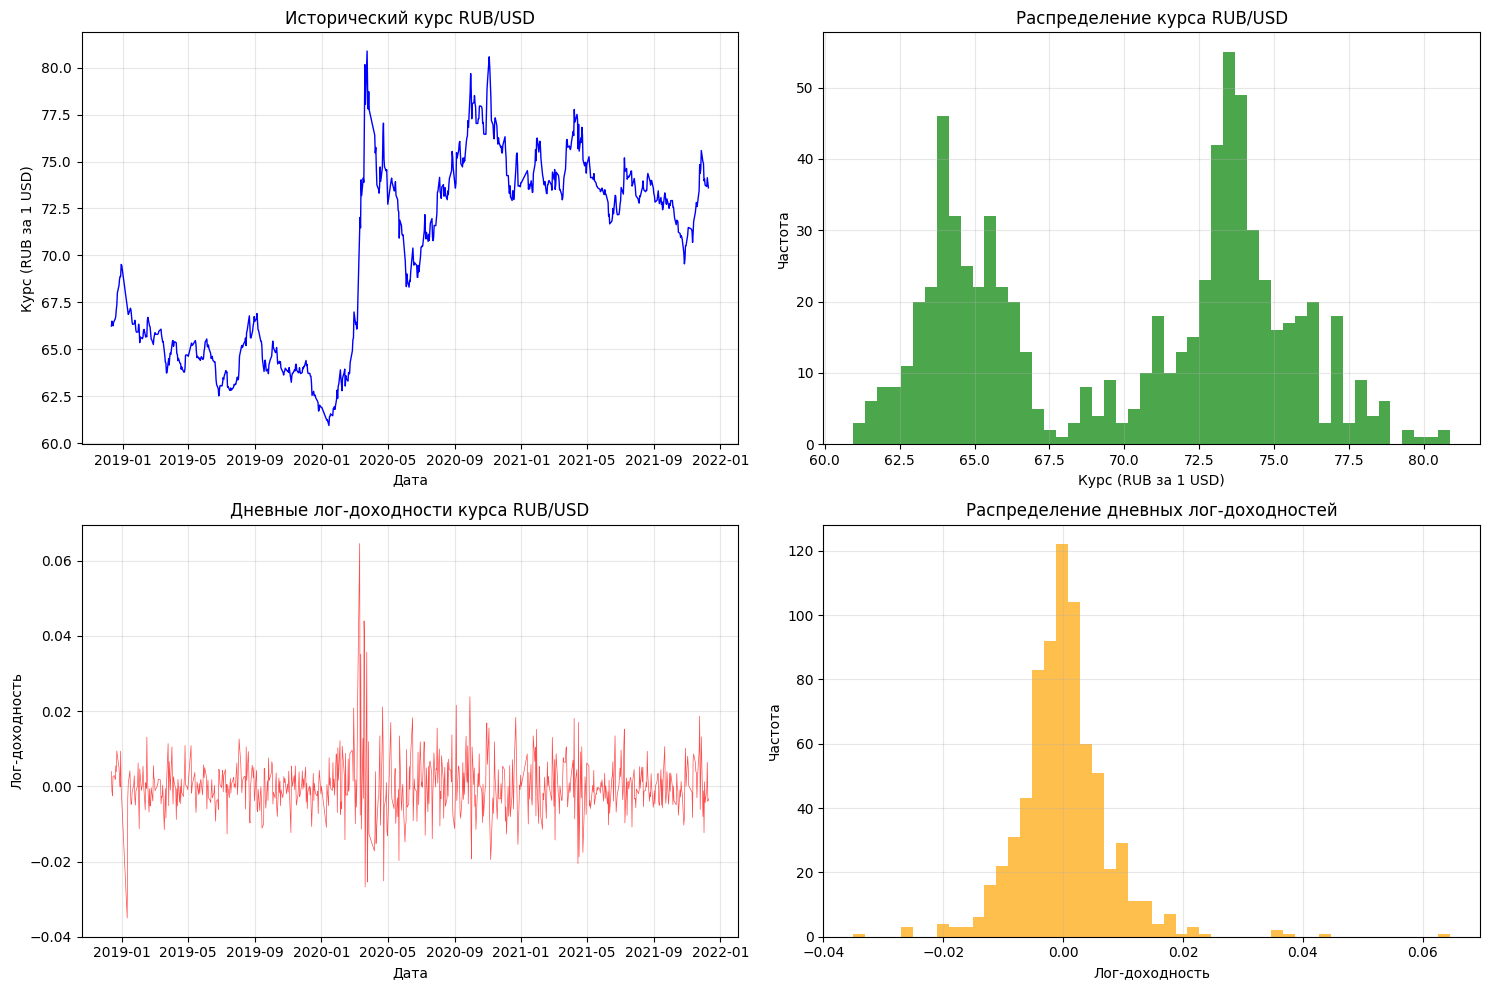

In [26]:
plot_fx_analysis(fx_hist, log_returns)

In [27]:
print_statistics(fx_hist["Rate"], data_type="fx")

СТАТИСТИКА ДАННЫХ (КУРС):
• Объем данных: 738 наблюдений
• Минимальный курс: 60.9474 RUB/USD
• Максимальный курс: 80.8815 RUB/USD
• Средний курс: 70.0776 RUB/USD
• Медиана: 71.7492 RUB/USD
• Стандартное отклонение: 4.9780 RUB/USD
• Коэффициент вариации: 0.0710

• 25-й перцентиль: 65.0605 RUB/USD
• 75-й перцентиль: 73.9897 RUB/USD
• IQR: 8.9293 RUB/USD

Анализ изменений курса:
• Среднее дневное изменение: 0.0100RUB/USD
• Волатильность изменений: 0.5599RUB/USD
• Макс. рост за день: 4.5033RUB/USD
• Макс. падение за день: -2.3911RUB/USD


Курс в выборке колеблется в диапазоне примерно 61–81 RUB/USD при среднем около 70 и медиане около 72, а коэффициент вариации ~7% говорит о средних относительных колебаниях.​

Дневные лог‑доходности в среднем близки к нулю, но с отдельными всплесками.

In [28]:
fx_params = calibrate_fx_model(log_returns)
fx_model = create_model(fx_params, "fx")
dates_fx_simple, trajectories_fx_simple = simulate_model(
    model=fx_model,
    initial_value=fx_initial,
    start_date=calc_date,
    end_date=end_date,
    n_paths=50,
    model_type="fx",
    mu_annual=fx_params["mu_annual"],
)



Калибровка FX модели...
   μ_дневной=0.000143, σ_дневной=0.007697
   μ_годовой=0.036016, σ_годовой=0.122183


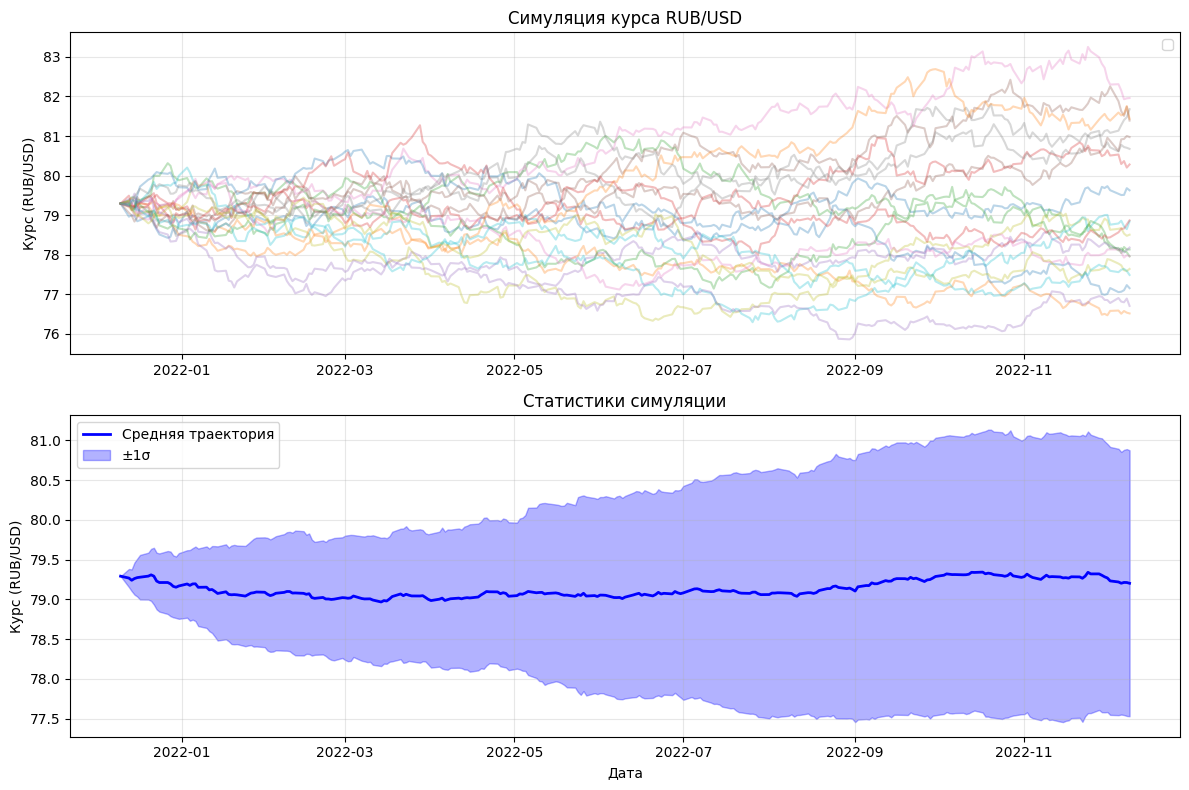

In [29]:
plot_simulation(
    dates=dates,
    trajectories=fx_initial * np.exp(trajectories),
    model_type="fx",
    title="Симуляция курса RUB/USD",
    asset_type="fx",
)

График отображает среднюю траекторию (основной тренд) и доверительный интервал (±1 стандартное отклонение). Симуляция демонстрирует небольшие колебания средней траектории, при этом вероятный диапазон колебаний на горизонте 1 года составляет 75-85 рублей.

In [30]:
logfx_best_params = {"sigma": 0.007697}

#### **Оценка корреляций между факторами**

In [31]:
size = min(sofr_df.shape[0], ruonia_df.shape[0], us_g_curve_df.shape[0], ru_g_curve_df.shape[0])
dt = 1 / 252

theta_arr_ru = get_theta_arr(ru_best_params, "2018-12-11", "2021-12-10", dt=dt)
theta_arr_ru = theta_arr_ru[-size:]


theta_arr_us = get_theta_arr(us_best_params, "2018-12-11", "2021-12-10", dt=dt)
theta_arr_us = theta_arr_us[-size:]

In [32]:
residuals_ru = get_cir_residuals(
    data=ruonia_df.Rate.values[-size:],
    theta=theta_arr_ru,
    alpha=ru_best_params["alpha"],
    dt=1 / 252,
)

residuals_us = get_cir_residuals(
    data=sofr_df.Rate.values[-size:], theta=theta_arr_us, alpha=us_best_params["alpha"], dt=1 / 252
)

residuals_fx = get_logfx_residuals(
    data_fx=fx_df.Rate.values[-size:],
    data_rd=ruonia_df.Rate.values[-size:],
    data_rf=sofr_df.Rate.values[-size:],
    sigma=logfx_best_params["sigma"],
    dt=dt,
)

In [33]:
m = np.stack((residuals_ru, residuals_us, residuals_fx), axis=0)
cov_mat = np.cov(m).round(2)
cov_mat

array([[1.  , 0.91, 0.03],
       [0.91, 1.  , 0.03],
       [0.03, 0.03, 1.  ]])

Анализ корреляций между остатками моделей показывает:

Высокая положительная корреляция (0.91) между ставками RUONIA и SOFR.

Практически нулевая корреляция (0.03) между валютным курсом RUB/USD и обеими процентными ставками.

Ковариационная матрица подтверждает адекватность моделей - остатки независимы от факторов, кроме ожидаемой сильной связи между двумя процентными ставками.

### **2. Оценка справедливой стоимости Range Accrual**

Продемонстрируем работу для оценки справедливой стоимости Range Accrual.

In [34]:
model_ru = CIRModel(**ru_best_params)
model_us = CIRModel(**us_best_params)
model_log_fx = FXLogModel(**logfx_best_params)

In [35]:
model = RangeAccrualPricingModel(model_us, model_ru, model_log_fx, cov_mat, seed=42)

In [36]:
sim_results = model.price(
    start_date="2021-12-10",
    end_date="2021-12-20",
    nominal=1000,
    lower_bound=None,
    upper_bound=0.01005,
    r0_domestic=0.04,
    r0_foreign=0.02,
    fx0=0.01,
    n_trajectories=100,
    return_trajectories=True,
)

print(sim_results.get("price"))

950.0


Для оценки количества симуляций посмотрим на зависимости стандартного отклонения
оценки стоимости от количества симуляций.

In [37]:
n_samples = 1000
n_trajectories_list = [100, 1000, 2500, 10_000, 15_000, 20_000, 25_000, 30_000]
std_list = []


for n_trajectories in n_trajectories_list:
    prices = []

    for _ in tqdm(range(n_samples)):
        price = model.price(
            start_date="2021-12-10",
            end_date="2021-12-20",
            nominal=1000,
            lower_bound=None,
            upper_bound=0.01005,
            r0_domestic=0.04,
            r0_foreign=0.02,
            fx0=0.01,
            n_trajectories=n_trajectories,
        )

        prices.append(price)

    std_list.append(np.std(prices))

100%|██████████| 1000/1000 [01:17<00:00, 12.97it/s]


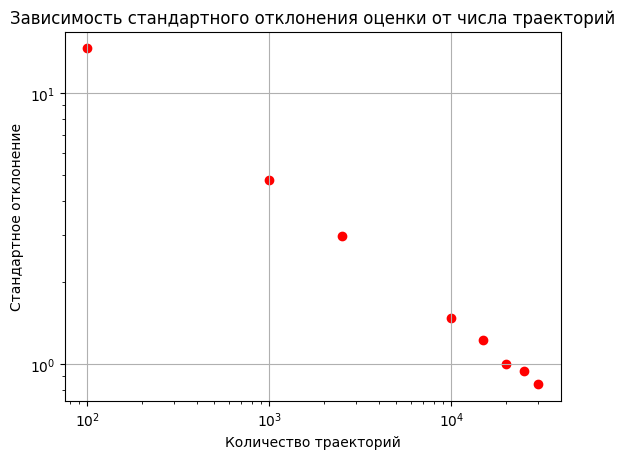

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(n_trajectories_list, std_list, color="red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Количество траекторий")
plt.ylabel("Стандартное отклонение")
plt.title("Зависимость стандартного отклонения оценки от числа траекторий")
plt.grid(True)
plt.show()

С учётом размера номинала при симуляциях можно использовать 1000 траекторий. В этом случае уровень стандартного отклонения становится менее 0.1% от размера номинала.

**Пояснение по выбору `dt`**

В финансовых рынках обычно предполагается, что в году 252 торговых дня. По этой причине значение `dt = 1 / 252` часто используется на практике для дискретизации.

# Основые выводы

В ходе работы на примере ставок RUONIA, SOFR и курса RUB/USD было продемонстрировано, что модели стохастических процессов, такие как CIR для ставок и логарифмическая модель для валюты, адекватно учитывают ключевые свойства финансовых временных рядов — возврат к среднему и волатильность и позволяют моделировать симуляционные процессы.

Правильная калибровка моделей является критически важным этапом. Как показано в работе, параметры моделей, в частности скорость возврата к среднему (alpha) и волатильность (sigma), должны оцениваться на репрезентативных исторических данных с помощью статистических методов, например — метода максимального правдоподобия. Это обеспечивает не только статистическую значимость параметров, но и выполнение теоретических условий, таких как условие Феллера для модели CIR, гарантирующее неотрицательность ставок.

Сравнение моделей с постоянной и переменной долгосрочной средней (theta) показало их сопоставимое качество при моделировании курса рубля, однако модель с переменной theta, основанная на бескупонной доходности, предоставляет более гибкий и экономически интерпретируемый инструмент. 

Ключевой вывод заключается в том, что для построения надежного прогноза необходимо:
1.  Учитывать структурные изменения на рынке, выбирая для калибровки релевантный исторический период, отражающий актуальные условия.
2.  Проводить симуляции методом Монте-Карло в достаточном количестве (тысячи траекторий) для обеспечения стабильности и точности оценок.
3.  Учитывать корреляции между различными факторами риска (например, между ставками разных стран).

Таким образом, надежный прогноз строится на строгой методологии, включающей обоснованный выбор моделей, их тщательную калибровку на осознанно подобранном периоде данных и валидацию получаемых результатов.